
# Trapezoidal method based on mean and standard deviation

##  import bibliotek

In [1]:
import datetime as dt
from datetime import datetime
from typing import Tuple, List
import random
import warnings

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
import seaborn as sns

from copy import deepcopy

from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py import discover_bpmn_inductive

warnings.filterwarnings("ignore")

## Function

### loading and processing data function

In [2]:
def convert_logs_to_start_complete_by_status(df:pd.DataFrame, status: 'str', timestamp: 'str') -> pd.DataFrame: 
    """
    from column timestamp and status [complete, start] generate a new two column start_timestamp and end_timestamp
    """
    df['start_timestamp'] = df.loc[df[status] == 'start', timestamp]
    df['complete_timestamp'] = df.loc[df[status] == 'complete', timestamp]
    df.drop([status, timestamp], axis=1, inplace=True)
    return df

def grouped_start_complete_timestamp_to_one_row(df: pd.DataFrame) -> pd.DataFrame:
    """
    grouped two rows first like [NaT, complete_timestamp] and second like [start_timestamp, NaT] 
    to one row [start_timestamp, complete_timestamp]
    """
    # choose column to be grouped - start_timestamp and complete_timestamp
    columns_grouped = [col for col in df.columns.values if (col != 'start_timestamp' and col != 'complete_timestamp')]
    grouped = df.groupby(columns_grouped, as_index=False)

    # Columns aggregation using first and last argument
    return grouped.agg({'start_timestamp': 'first', 'complete_timestamp': 'last'})

### ploting function

In [3]:
def plot_task_duration(df: pd.DataFrame, xlim: Tuple, ax: plt.Axes, color: str = 'r', label: str = ''):
    """
    generating a plot of one task logs, like a line in time.
    """
    for i in range(df.shape[0] - 1):
        ax.plot([np.array(df['start_timestamp'])[i], np.array(df['complete_timestamp'])[i]], [np.array(df['case:concept:name'])[i],np.array(df['case:concept:name'])[i]], color=color, alpha=0.5, label=label)
    ax.get_yaxis().set_visible(False)
    ax.set(xlim=xlim)
    
def plot_tasks(df: pd.DataFrame, task_col:str, list_of_tasks: List[str], xlim: Tuple, show_plot: bool = True, colors: List = None):
    """
    generating plot_task_duration for two analyzed tasks
    """
    if not colors:
        colors = [generate_random_color() for _ in range(len(list_of_tasks))]
    generate_random_color()
    if show_plot:
        fig, ax = plt.subplots(figsize=[14,6])
        for task_idx in range(len(list_of_tasks)):
            plot_task_duration(df.loc[df[task_col] == list_of_tasks[task_idx]], xlim=xlim, ax=ax, color=colors[task_idx], label=list_of_tasks[task_idx])
        # ręczne utworzenie legendy dla każdego wykresu
        handles, labels = ax.get_legend_handles_labels()
        unique_labels = list(set(labels))
        legend_handles = []
        legend_labels = []
        for label in unique_labels:
            index = labels.index(label)
            legend_handles.append(handles[index])
            legend_labels.append(labels[index])
        plt.legend(legend_handles, legend_labels)
        plt.tight_layout()
        plt.show()

def generate_random_color():
    r = random.randint(0, 255)
    g = random.choice([0, 255])
    b = random.choice([0, 255])
    return (r/255.0, g/255.0, b/255.0)
    

### core algorythm function

In [33]:
def selected_columns_to_compare(df:pd.DataFrame, instance_col: str, task_col: str, instance: str, task1: str, task2: str):
    return df.loc[(df[task_col] == task1) | (df[task_col] == task2) & (df[instance_col] == instance)]

def moved_to_side(df:pd.DataFrame, task_col: str, trace_col: str, task1: str, task2: str, side: str):
    """
    function moved to left or ride side of the first tasks
    """
    
    left_side = np.min(df.start_timestamp)
    right_side = np.min(df.complete_timestamp)
    
    for i in df[trace_col].unique():
        case1 = ((df[trace_col] == i) & (df[task_col] == task1))
        case2 = ((df[trace_col] == i) & (df[task_col] == task2))
        
        if side == 'left':
            diff = pd.to_datetime(df[case1].start_timestamp) - left_side
            
            df.loc[case1, 'start_timestamp'] = df.loc[case1, 'start_timestamp'] - diff.item()
            df.loc[case2, 'start_timestamp'] = df.loc[case2, 'start_timestamp'] - diff.item()
            df.loc[case1, 'complete_timestamp'] = df.loc[case1, 'complete_timestamp'] - diff.item()
            df.loc[case2, 'complete_timestamp'] = df.loc[case2, 'complete_timestamp'] - diff.item()
       
        elif side == 'right':
            diff = right_side - pd.to_datetime(df[case1].complete_timestamp) 
            
            df.loc[case1, 'start_timestamp'] = df.loc[case1, 'start_timestamp'] + diff.item()
            df.loc[case2, 'start_timestamp'] = df.loc[case2, 'start_timestamp'] + diff.item()
            df.loc[case1, 'complete_timestamp'] = df.loc[case1, 'complete_timestamp'] + diff.item()
            df.loc[case2, 'complete_timestamp'] = df.loc[case2, 'complete_timestamp'] + diff.item()
        else:
            break
    return df

def calculate_timestamp_metrics(df: pd.DataFrame, task_col: str, list_of_tasks: List, plot_result: bool = False, colors: List = ['m', 'y']):
    number_of_traces = df.groupby([task_col]).count()
    n_task1 = number_of_traces.iloc[0,0]
    n_task2 = number_of_traces.iloc[1,0]

    mean_start1 = np.mean(df[df[task_col] == list_of_tasks[0]].start_timestamp)
    mean_start2 = np.mean(df[df[task_col] == list_of_tasks[1]].start_timestamp)

    mean_complete1 = np.mean(df[df[task_col] == list_of_tasks[0]].complete_timestamp)
    mean_complete2 = np.mean(df[df[task_col] == list_of_tasks[1]].complete_timestamp)

    std_start1 = np.std(df[df[task_col] == list_of_tasks[0]].start_timestamp)
    std_start2 = np.std(df[df[task_col] == list_of_tasks[1]].start_timestamp)

    std_complete1 = np.std(df[df[task_col] == list_of_tasks[0]].complete_timestamp)
    std_complete2 = np.std(df[df[task_col] == list_of_tasks[1]].complete_timestamp)
    
    
    if plot_result:
        _, ax = plt.subplots(figsize=[14,6])
        ax.plot([mean_start1, mean_complete1, mean_complete1 + std_complete1, mean_start1-std_start1, mean_start1], [n_task1, n_task1, 0, 0, n_task1], colors[0], linewidth=2, linestyle="--")
        ax.plot([mean_start2, mean_complete2, mean_complete2 + std_complete2, mean_start2-std_start2, mean_start2], [n_task2, n_task2, 0, 0, n_task2], colors[1], linewidth=2, linestyle="--")
        ax.set(xlim=(xlim_lower, xlim_upper), ylim=(0, 1.1*np.max([n_task1,n_task2])))
        ax.get_yaxis().set_visible(False)
        plt.legend(list_of_tasks)
        plt.tight_layout()
        plt.show()
    
    area_task1 = (2 * (mean_complete1 - mean_start1) + std_start1 + std_complete1).days * n_task1
    area_task2 = (2 * (mean_complete2 - mean_start2) + std_start2 + std_complete2).days * n_task2
    
    y = (n_task2/std_start2.days)*(dt.timedelta(0) - (mean_start2 - std_start2 - mean_complete1)).days

    if y > 0 and y is not None:
        area_splot = ((mean_complete1 + std_complete1) - (mean_start2 - std_start2)).days * y
    else:
        area_splot = dt.timedelta(0).days

    return (area_task1, area_task2, area_splot)


def core_method(df: pd.DataFrame, instance_col: str, trace_col: str, task_col: str, list_of_tasks: List, show_plot: bool = False, colors: List = None):
    
    selected_df = selected_columns_to_compare(df, instance_col=instance_col, task_col=task_col, instance=instance, task1=task1, task2=task2)
    plot_tasks(selected_df, task_col=task_col, list_of_tasks=[task1, task2], xlim=(xlim_lower, xlim_upper), show_plot=show_plot, colors=colors)
    
    df1 = moved_to_side(selected_df, task_col=task_col, trace_col=trace_col,task1=task1, task2=task2, side='right')
    plot_tasks(df1, task_col=task_col, list_of_tasks=[task1, task2], xlim=(xlim_lower, xlim_upper),show_plot=show_plot, colors=colors)

    [area_task1, area_task2, area_splot] = calculate_timestamp_metrics(df1, task_col=task_col, list_of_tasks=[task1, task2], plot_result=show_plot, colors=colors)

#     print(np.max([len(task1),len(task2)]) * "= ")
    print(30*"= ")
    print("{0} area:\033[1m {1} \033[0m".format(task1, area_task1))
    print("{0} area:\033[1m {1} \033[0m".format(task2, area_task2))
    print("splot area:\033[1m {} \033[0m".format(round(area_splot,2)))
    print("\nsplot/task1:\033[1m {} % \033[0m".format(round(100 * area_splot/area_task1), 2))
    print("splot/task2:\033[1m {} % \033[0m".format(round(100 * area_splot/area_task2), 2))
    print("")

### Załadowanie pliku formatu .xes

In [5]:
log = xes_importer.apply('logs/exercise6.xes')

parsing log, completed traces ::   0%|          | 0/132 [00:00<?, ?it/s]

### Przetworzenie logów do pd.Dataframe

In [6]:
df = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)

### Podgląd logow znajdujących się w załadowanym pliku

In [7]:
df.head()

,org:resource,time:timestamp,concept:name,lifecycle:transition,case:concept:name
0,Call Centre Agent,2005-12-31 23:00:00+00:00,check if sufficient information is available,start,0
1,Call Centre Agent,2006-01-13 23:00:00+00:00,check if sufficient information is available,complete,0
2,Call Centre Agent,2006-01-13 23:00:00+00:00,register claim,start,0
3,Call Centre Agent,2008-01-29 23:00:00+00:00,register claim,complete,0
4,Claims handler,2008-01-29 23:00:00+00:00,determine likelihood of claim,start,0


In [8]:
print(df.groupby(['lifecycle:transition'])['lifecycle:transition'].count())

lifecycle:transition
complete    821
start       821
Name: lifecycle:transition, dtype: int64


### Zamiana logów na format zawierający star_timestamp oraz complete_timestamp

In [9]:
df = convert_logs_to_start_complete_by_status(df, 'lifecycle:transition', 'time:timestamp')
df = grouped_start_complete_timestamp_to_one_row(df)
df.head()

,org:resource,concept:name,case:concept:name,start_timestamp,complete_timestamp
0,Call Centre Agent,check if sufficient information is available,0,2005-12-31 23:00:00+00:00,2006-01-13 23:00:00+00:00
1,Call Centre Agent,check if sufficient information is available,1,2005-12-31 23:00:00+00:00,2006-03-07 23:00:00+00:00
2,Call Centre Agent,check if sufficient information is available,10,2006-03-30 23:00:00+00:00,2006-04-09 23:00:00+00:00
3,Call Centre Agent,check if sufficient information is available,100,2008-07-26 23:00:00+00:00,2008-09-16 23:00:00+00:00
4,Call Centre Agent,check if sufficient information is available,101,2007-11-13 23:00:00+00:00,2008-01-19 23:00:00+00:00


In [10]:
df['org:resource'].unique()

array(['Call Centre Agent', 'Claims handler'], dtype=object)

# Analiza położenia zadań:

### Analiza 'org:resource' == 'Call Centre Agent'

In [11]:
call_centre_agent = df.loc[df['org:resource'] == 'Call Centre Agent']
list_of_tasks = call_centre_agent['concept:name'].unique()
print(list_of_tasks)

['check if sufficient information is available' 'end' 'register claim']


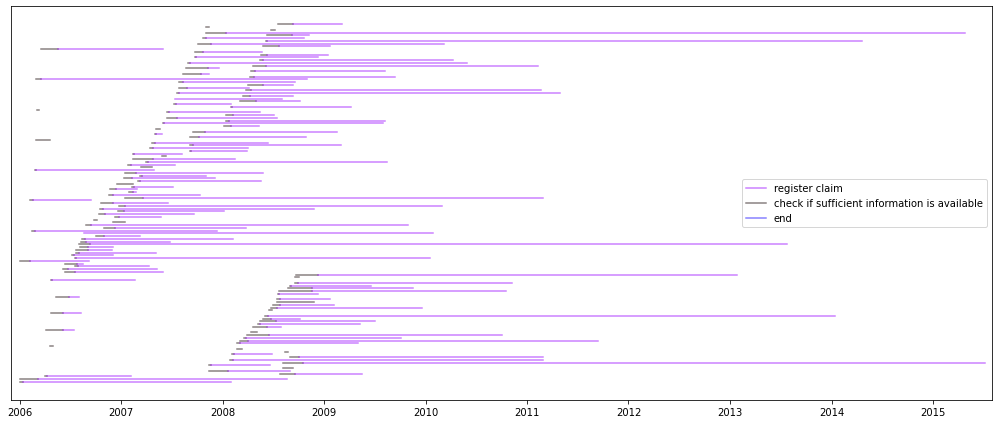

In [12]:
xlim_lower = datetime.strptime('2005-12-01', '%Y-%m-%d')
xlim_upper = datetime.strptime('2015-08-01', '%Y-%m-%d')

plot_tasks(df=call_centre_agent, task_col='concept:name', list_of_tasks=list_of_tasks, xlim=(xlim_lower, xlim_upper))

In [34]:
xlim_lower = datetime.strptime('2005-10-01', '%Y-%m-%d')
xlim_upper = datetime.strptime('2015-08-01', '%Y-%m-%d')


instance_col = 'org:resource'
task_col = 'concept:name'
trace_col = 'case:concept:name'

instance = 'Call Centre Agent'
task1 = 'check if sufficient information is available'
task2 = 'register claim'

colors = ['magenta', 'orange']

core_method(df, instance_col=instance_col, trace_col=trace_col, task_col=task_col, list_of_tasks=[task1, task2], show_plot=False, colors=colors)

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
check if sufficient information is available area: 10560 
register claim area: 178020 
splot area: 0 

splot/task1: 0 % 
splot/task2: 0 % 



### Analiza 'org:resource' == 'Claims handler'

In [29]:
claims_handler = df.loc[df['org:resource'] == 'Claims handler']
list_of_tasks = df['concept:name'].unique()
print(list_of_tasks)

['check if sufficient information is available' 'end' 'register claim'
 'advise claimant on reimbursement' 'assess claim' 'close claim'
 'determine likelihood of claim' 'initiate payment']


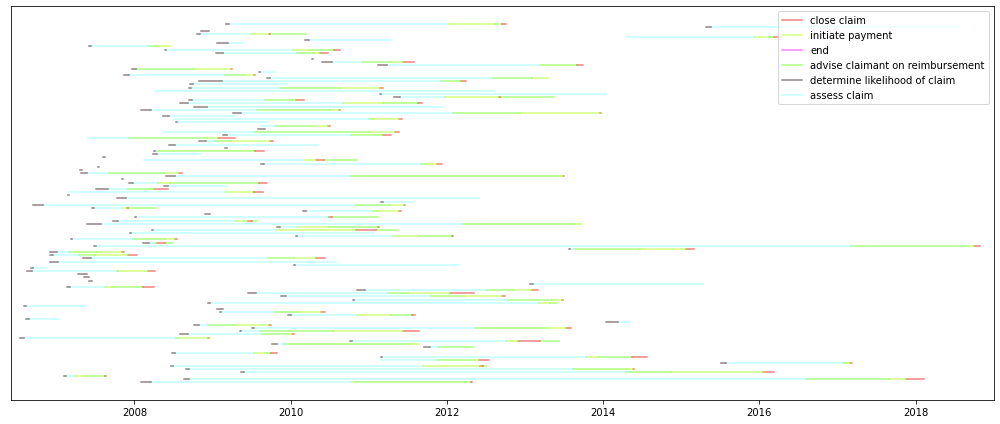

In [35]:
xlim_lower = datetime.strptime('2006-06-01', '%Y-%m-%d')
xlim_upper = datetime.strptime('2019-01-01', '%Y-%m-%d')

plot_tasks(df=claims_handler, task_col='concept:name', list_of_tasks=list_of_tasks, xlim=(xlim_lower, xlim_upper))

In [36]:
xlim_lower = datetime.strptime('2005-06-01', '%Y-%m-%d')
xlim_upper = datetime.strptime('2019-01-01', '%Y-%m-%d')

instance_col = 'org:resource'
task_col = 'concept:name'
trace_col = 'case:concept:name'

instance = 'Claims handler'
colors = ['magenta', 'orange']

In [37]:
task_in_order = ['determine likelihood of claim', 'assess claim', 'advise claimant on reimbursement', 'initiate payment', 'close claim']
for i in range(len(task_in_order)):
    for j in range(i + 1, len(task_in_order)):
        task1 = task_in_order[i]
        task2 = task_in_order[j]
        core_method(df=claims_handler, instance_col=instance_col, trace_col=trace_col, task_col=task_col, list_of_tasks=[task1, task2], show_plot=False, colors=colors)

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
determine likelihood of claim area: 5544 
assess claim area: 205850 
splot area: 0 

splot/task1: 0 % 
splot/task2: 0 % 

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
determine likelihood of claim area: 4256 
advise claimant on reimbursement area: 191360 
splot area: 0 

splot/task1: 0 % 
splot/task2: 0 % 

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
determine likelihood of claim area: 6440 
initiate payment area: 119548 
splot area: 0 

splot/task1: 0 % 
splot/task2: 0 % 

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
determine likelihood of claim area: 4256 
close claim area: 163875 
splot area: 0 

splot/task1: 0 % 
splot/task2: 0 % 

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
assess claim area: 136040 
advise claimant on reimbursement area: 61974 
splot area: 1955.56 

splot/task1: 1 % 
splot/task2: 3 % 

= = = = = = = = = = = = = = = = = = = = = = = = = = 

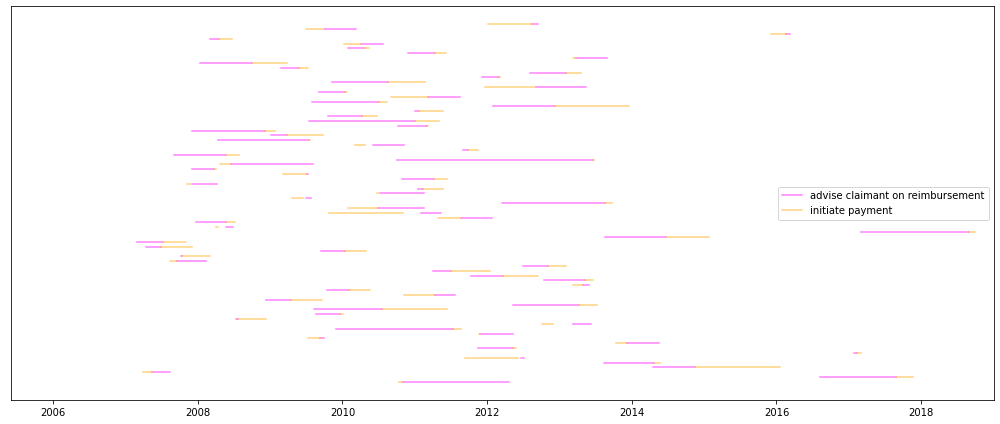

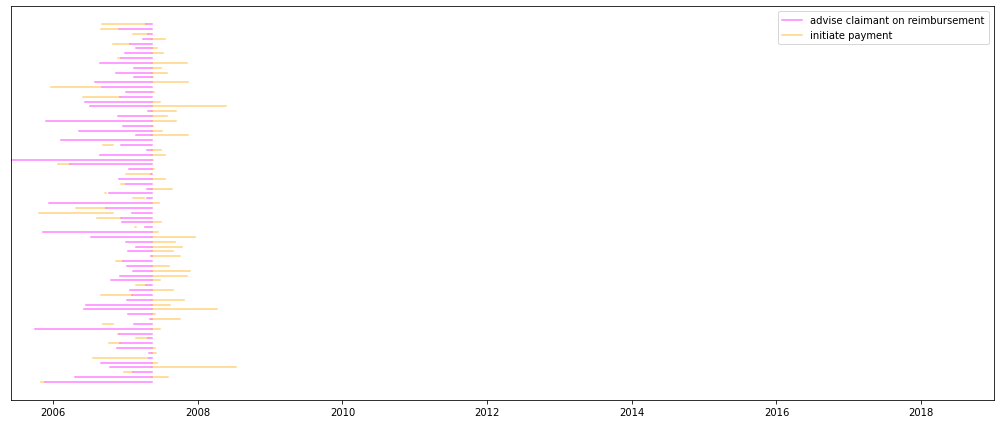

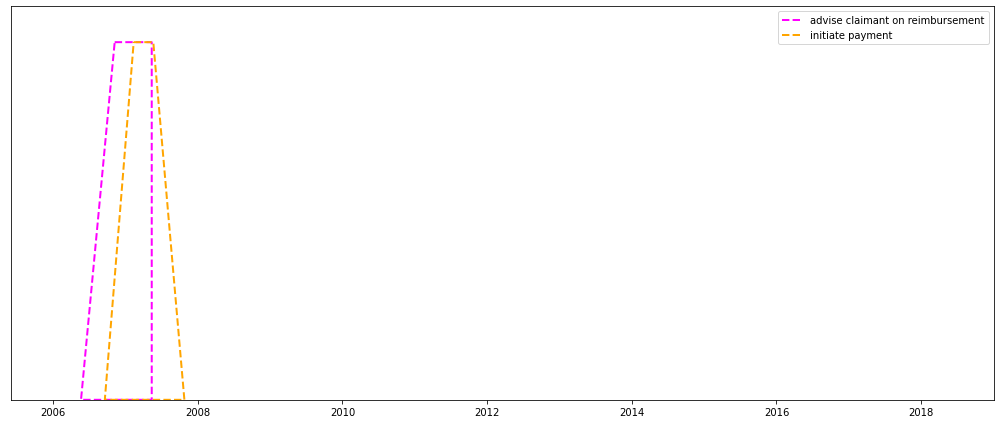



= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
advise claimant on reimbursement area: 41268 
initiate payment area: 38000 
splot area: 29192.39 

splot/task1: 71 % 
splot/task2: 77 % 
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


In [20]:
task1 = 'advise claimant on reimbursement'
task2 = 'initiate payment'

core_method(df=claims_handler, instance_col=instance_col, trace_col=trace_col, task_col=task_col, list_of_tasks=[task1, task2], show_plot=True, colors=colors)

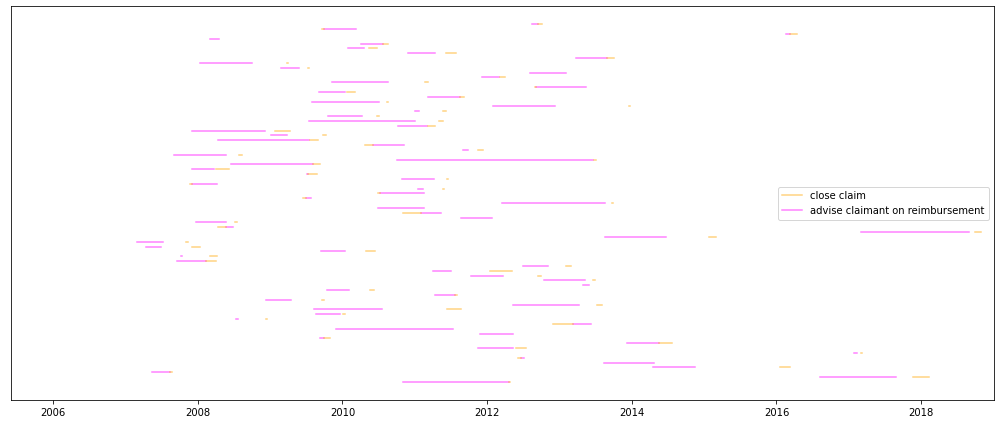

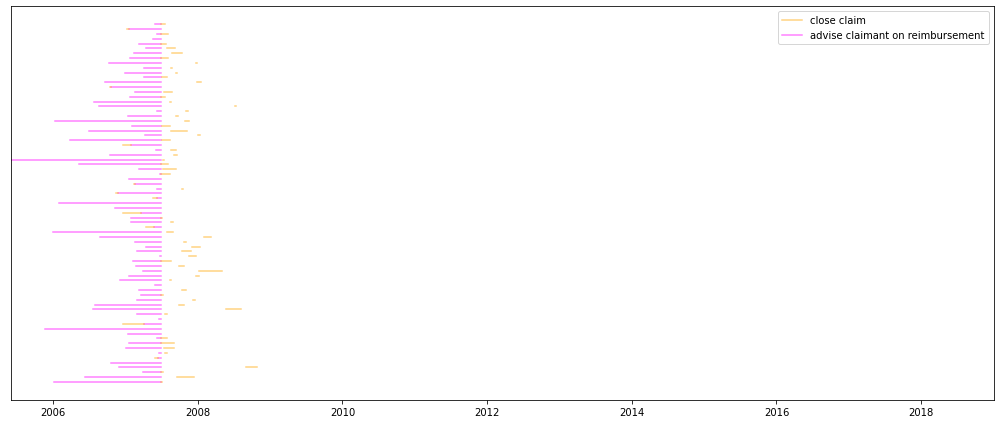

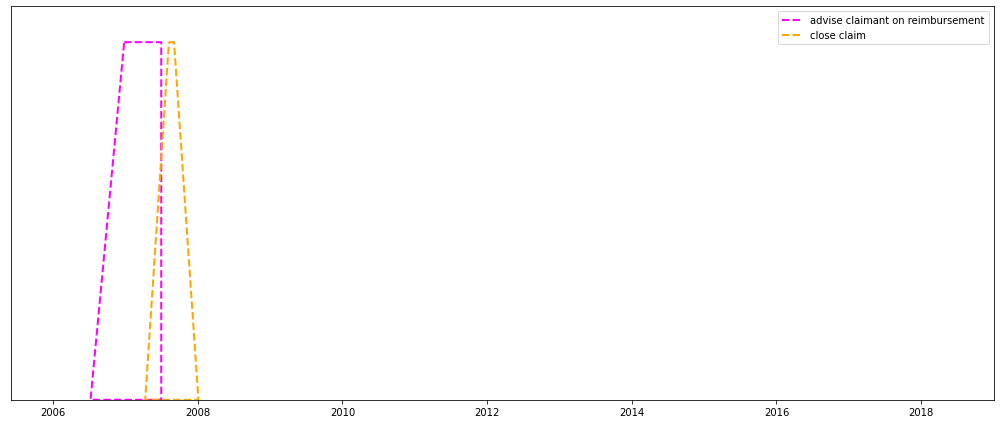



= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
advise claimant on reimbursement area: 41268 
close claim area: 22344 
splot area: 4087.39 

splot/task1: 10 % 
splot/task2: 18 % 
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


In [21]:
task1 = 'advise claimant on reimbursement'
task2 = 'close claim'

core_method(df=claims_handler, instance_col=instance_col, trace_col=trace_col, task_col=task_col, list_of_tasks=[task1, task2], show_plot=True, colors=colors)

In [ ]:
task1 = 'determine likelihood of claim'
task2 = 'close claim'

core_method(df=claims_handler, instance_col=instance_col, trace_col=trace_col, task_col=task_col, list_of_tasks=[task1, task2], show_plot=True, colors=colors)

In [ ]:
task1 = 'assess claim'
task2 = 'close claim'

core_method(df=claims_handler, instance_col=instance_col, trace_col=trace_col, task_col=task_col, list_of_tasks=[task1, task2], show_plot=False, colors=colors)

In [ ]:
task1 = 'assess claim'
task2 = 'initiate payment'

core_method(df=claims_handler, instance_col=instance_col, trace_col=trace_col, task_col=task_col, list_of_tasks=[task1, task2], show_plot=False, colors=colors)